In [56]:
import pandas as pd
import numpy as np
data = pd.read_csv("khc01221.txt")

In [57]:
def timecut(data):
    temps = pd.DataFrame()
    x=[0.1,11/30,0.9,0.1,0.9,0.9,0.1,19/30,19/30,11/30,19/30,11/30,11/30,0.9,0.1,19/30]
    y = [0.1,19/30,0.9,11/30,19/30,0.1,0.9,0.9,0.1,0.9,19/30,0.1,11/30,11/30,19/30,11/30]
    for i in range(0, 16):
        temp = pd.DataFrame({"X": data.ALX.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)],
                            "Y": data.ALY.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)]})
        temp = pd.concat([temp.reset_index(), pd.DataFrame( {"x":[x[i]]*temp.shape[0]} ), pd.DataFrame({"y":[y[i]]*temp.shape[0]}) ], axis = 1)
        temps = pd.concat([temps, temp])
    return temps

def timemean(data):
    temps = pd.DataFrame()
    x=[0.1,11/30,0.9,0.1,0.9,0.9,0.1,19/30,19/30,11/30,19/30,11/30,11/30,0.9,0.1,19/30]
    y = [0.1,19/30,0.9,11/30,19/30,0.1,0.9,0.9,0.1,0.9,19/30,0.1,11/30,11/30,19/30,11/30]
    for i in range(0, 16):
        temp = pd.DataFrame(pd.DataFrame({"X": data.ALX.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)],
                            "Y": data.ALY.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)]}).apply(np.mean)).transpose()
        temp = pd.concat([temp, pd.DataFrame( {"x":[x[i]]*temp.shape[0]} ), pd.DataFrame({"y":[y[i]]*temp.shape[0]}) ], axis = 1)
        temps = pd.concat([temps, temp])
    return temps

def times(data):
    temps = pd.DataFrame()
    x=[0.1,11/30,0.9,0.1,0.9,0.9,0.1,19/30,19/30,11/30,19/30,11/30,11/30,0.9,0.1,19/30]
    y = [0.1,19/30,0.9,11/30,19/30,0.1,0.9,0.9,0.1,0.9,19/30,0.1,11/30,11/30,19/30,11/30]
    for i in range(0, 16):
        temp = pd.DataFrame(pd.DataFrame({"X": data.ALX.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)],
                            "Y": data.ALY.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)]}).apply(np.mean)).transpose()
        temp = pd.concat([temp, pd.DataFrame(pd.DataFrame({"X": data.ALX.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)],
                            "Y": data.ALY.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)]}).apply(np.median)).transpose()])
        temp = pd.concat([temp.reset_index(), pd.DataFrame( {"x":[x[i]]*temp.shape[0]} ),  pd.DataFrame({"y":[y[i]]*temp.shape[0]}) ], axis = 1)
        temps = pd.concat([temps, temp])
    return temps


In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V

In [59]:
from torch.utils.data import Dataset, DataLoader

class dss(Dataset):
    def __init__(self, a):
        a = timecut(a).iloc[:,1:5]
        self.len = a.shape[0]
        self.x_data = torch.from_numpy(a.iloc[:,0:2].values).float()
        self.y_data = torch.from_numpy(a.iloc[:,2:4].values).float()
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len

size = len(data)
indices = list(range(size))
split = int(np.floor(0.3 * size))
np.random.seed(123)
np.random.shuffle(indices)

train_indices, test_indices = indices[split:], indices[:split]
train_data=data.iloc[train_indices, :]
test_data = data.iloc[test_indices, :]
dstrain = dss(train_data)
dstest = dss(test_data)
trainloader = DataLoader(dataset = dstrain, batch_size = 32, shuffle = True)
testloader = DataLoader(dataset = dstest, batch_size = 32, shuffle = False)

In [60]:
class optim2(nn.Module):
    
    def __init__(self, inputs, H, H2,outputs):
        super(optim2, self).__init__()
        self.linear1 = torch.nn.Linear(inputs, H)
        self.linear2 = torch.nn.Linear(H, H2)
        self.linear3 = torch.nn.Linear(H2, outputs)
        
    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        h_relu2 = self.linear2(h_relu).clamp(min=0)
        y_pred = self.linear3(h_relu2)
        return y_pred

In [61]:
inputs, H, H2,outputs = 2, 20, 10,2
for_graph = []; test_loss = []

model = optim2(inputs, H, H2,outputs)
criteria = torch.nn.MSELoss(size_average= False)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

for t in range(300):
    for i, datas in enumerate(trainloader):
        In, label = datas
        In, label = V(In), V(label)
        y_pred = model(In)
        loss = criteria(y_pred, label)
        for_graph.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % 100 == 99:
            with torch.no_grad():
                for datass in testloader:
                    In, label = datass
                    outputs = model(In)
                    test_loss.append(np.sum((label.numpy() - outputs.numpy())**2))

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

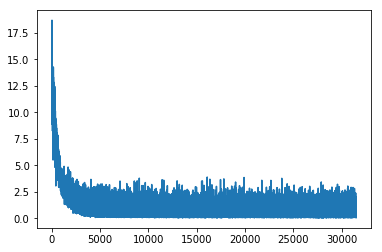

In [63]:
plt.plot(np.arange(len(for_graph)), for_graph)

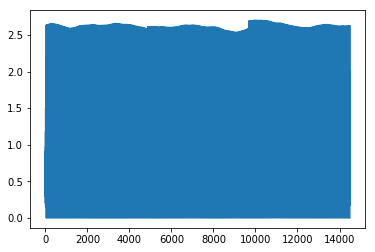

In [64]:
plt.plot(np.arange(len(test_loss)), test_loss)

(-0.1, 1)

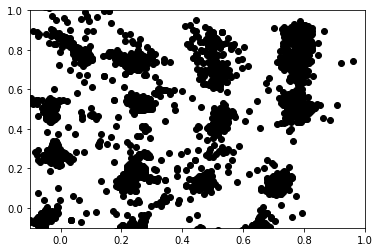

In [65]:
plt.scatter(data.ALX, data.ALY, c = "black");plt.xlim(-0.1,1);plt.ylim(-0.1,1)

In [66]:
out = pd.DataFrame(model(torch.from_numpy(data.iloc[:,2:4].values).float()).detach().numpy())

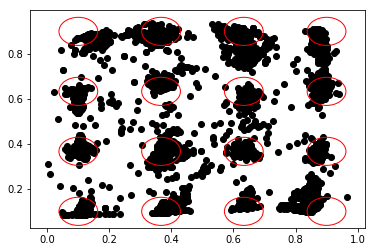

In [78]:
ax = plt.gca()
ax.scatter(out.iloc[:,0], out.iloc[:,1], c= "black")
x=[0.1,11/30,0.9,0.1,0.9,0.9,0.1,19/30,19/30,11/30,19/30,11/30,11/30,0.9,0.1,19/30]
y=[0.1,19/30,0.9,11/30,19/30,0.1,0.9,0.9,0.1,0.9,19/30,0.1,11/30,11/30,19/30,11/30]
for i in range(len(x)):
    temp = plt.Circle((x[i], y[i]), 1/16, color = "r", fill = False)
    ax.add_artist(temp)
